In [1]:
import numpy as np
import pandas as pd

import os
import shutil
from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
comp_name = "house-prices-advanced-regression-techniques"

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

## Collect data with kaggle api

In [9]:
api.competition_download_files(comp_name)

filename = comp_name + ".zip"
os.mkdir("data")
arch_path = os.path.join("data", filename)

shutil.move(filename, arch_path)

file = ZipFile(arch_path)
file.extractall("data")

## First look

In [171]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [168]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
train.head()

Train shape: (1460, 82)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotIsEmpty
0,1,60,RL,65.0,8450,Pave,NoAcc,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,65
1,2,20,RL,80.0,9600,Pave,NoAcc,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,80
2,3,60,RL,68.0,11250,Pave,NoAcc,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,68
3,4,70,RL,60.0,9550,Pave,NoAcc,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,60
4,5,60,RL,84.0,14260,Pave,NoAcc,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,84


In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

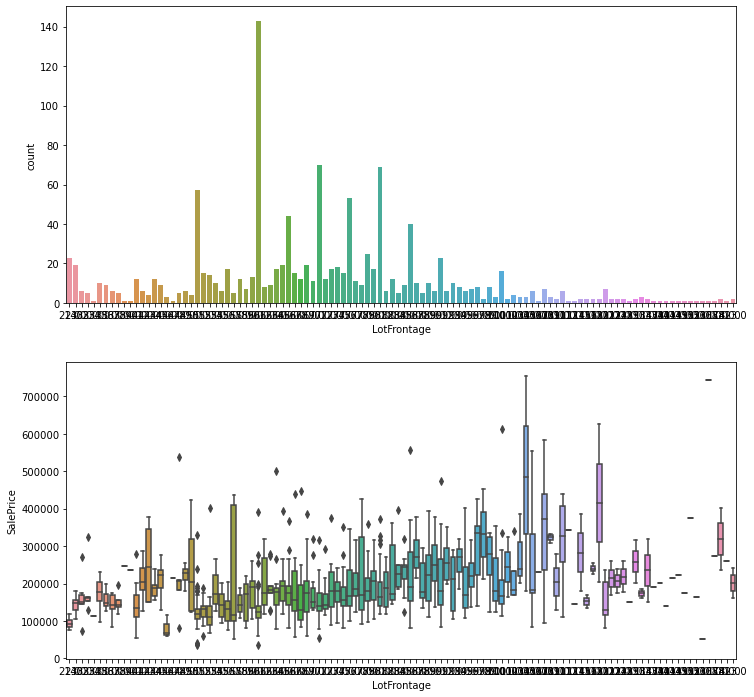

In [160]:
fig, axs = plt.subplots(2, 1, figsize=(12,12))
sns.countplot(x=train.LotFrontage, ax=axs[0])
sns.boxplot(x=train.LotFrontage, y=train.SalePrice, ax=axs[1])

In [181]:
train[train["Electrical"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NoAcc,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


### Work with features

In [21]:
prep_df = train.copy()

In [130]:
prep_df["MSSubClass"] = prep_df["MSSubClass"].astype("object")

#prep_df["LotFrontage"] = prep_df["LotFrontage"].clip(0, 150)

#prep_df["LotArea"] = prep_df["LotArea"].clip(0, 60000)

# prep_df["Street"] = prep_df["Street"].map({"Pave": 0, "Grvl":1})
# prep_df["Street"] = prep_df["Street"].astype("uint8")

prep_df["Alley"] = prep_df["Alley"].replace(np.nan, "NoAcc")
prep_df["AlleyAcc"] = prep_df["Alley"].apply(lambda x: 0 if x == "NoAcc" else 1)

prep_df["LotShapeReg"] = prep_df["LotShape"].apply(lambda x: 1 if x == "Reg" else 0)

prep_df["LandContourNotLvl"] = prep_df["LandContour"].apply(lambda x: 0 if x == "Lvl" else 1)

# prep_df["Utilities"] = prep_df["Utilities"].apply(lambda x: 0 if x == "AllPub" else 1)

prep_df["LandSlopeNotGtl"] = prep_df["LandSlope"].apply(lambda x: 0 if x == "Gtl" else 1)

# prep_df["Condition1"] = prep_df["Condition1"].apply(lambda x: 0 if x == "Norm" else 1)

prep_df["OverallQual"] = prep_df["OverallQual"].astype("object")
prep_df["OverallCond"] = prep_df["OverallCond"].astype("object")

#prep_df["YearBuilt"] = round(prep_df["YearBuilt"] / 10) * 10
#prep_df["YearBuilt"] = prep_df["YearBuilt"].astype("int32")
#prep_df["YearRemodAdd"] = round(prep_df["YearRemodAdd"] / 10) * 10
#prep_df["YearRemodAdd"] = prep_df["YearRemodAdd"].astype("int32")
#prep_df["YearBuilt"] = prep_df["YearBuilt"].astype("object")
#prep_df["YearRemodAdd"] = prep_df["YearRemodAdd"].astype("object")

prep_df["RemodAdd"] = prep_df["YearRemodAdd"] - prep_df["YearBuilt"]
prep_df["RemodAdd"] = prep_df["RemodAdd"].apply(lambda x: 0 if x == 0 else 1)
prep_df["RemodInPastDecade"] = (2000 - prep_df["YearRemodAdd"]) <= 0
prep_df["RemodInPastDecade"] = prep_df["RemodInPastDecade"].astype("uint8")
prep_df["YearsFromRemod"] = 2010 - prep_df["YearRemodAdd"]

prep_df["NotGableRoof"] = prep_df["RoofStyle"].apply(lambda x: 0 if x == "Gable" else 1)

prep_df["RoofMatlNotComp"] = prep_df["RoofMatl"].apply(lambda x: 0 if x == "CompShg" else 1)



In [178]:
train["Alley"] = train["Alley"].replace(np.nan, "NoAcc")
train["MasVnrType"] = train["MasVnrType"].replace(np.nan, "None")
train["MasVnrArea"] = train["MasVnrArea"].replace(np.nan, 0)
# train["LotFrontage"] = train["LotFrontage"].replace(np.nan, 0)

train["FireplaceQu"] = train["FireplaceQu"].replace(np.nan, "NoFireplace")

# Model

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

features = ["MSSubClass", "MSZoning", "LotFrontage", "LotArea", "AlleyAcc",
            "LotShapeReg", "LandContourNotLvl",
           "LandSlopeNotGtl", "OverallQual", "OverallCond", "YearRemodAdd", "Exterior1st",
           "Exterior2nd", "ExterQual", "BsmtQual", "BsmtExposure", "BsmtFinType1",
           "BsmtFinSF1", "BsmtFinType2", "BsmtUnfSF", "TotalBsmtSF", "Heating",
           "HeatingQC", "Electrical", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
           "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr",
           "Functional", "Fireplaces", "GarageCond", "WoodDeckSF", "EnclosedPorch",
           "3SsnPorch", "PoolQC", "Fence", "MiscFeature", "MiscVal", "MoSold",
           "YrSold", "SaleType"]


not_in_featrues = ["Id", "Alley", "LotShape", "LandContour", "LandSlope",
                   "Utilities", "Street", "LotConfig", "Neighborhood", "Condition1",
                  "Condition2", "HouseStyle", "YearBuilt", "RemodAdd", "RemodInPastDecade",
                  "YearsFromRemod", "RoofStyle", "NotGableRoof", "RoofMatl",
                   "RoofMatlNotComp", "MasVnrType", "MasVnrArea", "ExterCond",
                  "Foundation", "BsmtCond", "BsmtFinSF2", "CentralAir", "GrLivArea",
                  "KitchenAbvGr", "KitchenQual", "TotRmsAbvGrd", "FireplaceQu", "GarageType",
                  "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual",
                  "PavedDrive", "OpenPorchSF", "ScreenPorch", "PoolArea", "SaleCondition"]

x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(prep_df.drop(["SalePrice"], axis=1)),
                                                    prep_df["SalePrice"],
                                                   random_state=42, test_size=0.2)



model = XGBRegressor()
model.fit(x_train, y_train)
prediction = model.predict(x_test)
print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test, prediction))))

[15:26:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.14794531110843973


In [179]:
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(train.drop(["SalePrice"], axis=1)),
                                                    train["SalePrice"],
                                                    random_state=42, test_size=0.2)


model = XGBRegressor()
model.fit(x_train, y_train)
prediction = model.predict(x_test)
print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test, prediction))))

[15:53:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.1395975986599187


In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC